In [1]:
import gymnasium as gym
import numpy as np
import cv2
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

In [2]:
# --- Config ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_ACTIONS = 5
FRAME_STACK = 4
IMG_SIZE = 48
EPS_DECAY = 100_000  # decay steps
MAX_MEMORY = 10_000
BATCH_SIZE = 64
GAMMA = 0.99
LR = 2.5e-4
TARGET_UPDATE = 1000

In [3]:
# --- Preprocessing ---
def preprocess(obs):
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    obs = obs[int(obs.shape[0]*0.4):]  # Crop top 40%
    obs = cv2.resize(obs, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    return obs / 255.0

In [14]:
# --- Q-Network ---
class CNN(nn.Module):
    def __init__(self, in_channels, n_actions):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 256), nn.ReLU(),  # Fixed input size to match conv output
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        return self.net(x)

In [12]:
# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        indices = random.sample(range(len(self.buffer)), batch_size)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in indices])
        
        # Convert each component to the appropriate tensor type
        states = torch.tensor(np.array(states), device=DEVICE, dtype=torch.float32)
        actions = torch.tensor(np.array(actions), device=DEVICE, dtype=torch.int64)
        rewards = torch.tensor(np.array(rewards), device=DEVICE, dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), device=DEVICE, dtype=torch.float32)
        dones = torch.tensor(np.array(dones), device=DEVICE, dtype=torch.float32)
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer) 

In [5]:
import matplotlib.pyplot as plt
import pygame

In [19]:
# --- Training Loop ---
def train(env_name="CarRacing-v2", episodes=1000):
    env = gym.make(env_name, render_mode=None, continuous=False)
    q_net = CNN(FRAME_STACK, N_ACTIONS).to(DEVICE)
    target_net = CNN(FRAME_STACK, N_ACTIONS).to(DEVICE)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = optim.Adam(q_net.parameters(), lr=LR)
    memory = ReplayBuffer(MAX_MEMORY)

    steps_done = 0
    epsilon = 1.0
    decay_rate = 1 / EPS_DECAY

    frame_stack = deque(maxlen=FRAME_STACK)
    rewards_plot = []

    for episode in range(episodes):
        print(f"Episode {episode}")
        obs, _ = env.reset()
        obs = preprocess(obs)
        frame_stack.clear()
        for _ in range(FRAME_STACK):
            frame_stack.append(obs)
        state = np.stack(frame_stack, axis=0)

        total_reward = 0
        done = False
        while not done:
            # ε-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(DEVICE)
                    q_values = q_net(state_tensor)
                    action = q_values.argmax(1).item()

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_obs = preprocess(next_obs)
            frame_stack.append(next_obs)
            next_state = np.stack(frame_stack, axis=0)

            memory.push(state, action, reward, next_state, float(done))
            state = next_state
            total_reward += reward
            steps_done += 1
            epsilon = max(0.05, epsilon - decay_rate)

            # Learn
            if len(memory) >= BATCH_SIZE:
                states, actions, rewards, next_states, dones = memory.sample(BATCH_SIZE)
                q_vals = q_net(states).gather(1, actions.long().unsqueeze(1)).squeeze(1)
                next_q_vals = target_net(next_states).max(1)[0]
                targets = rewards + GAMMA * next_q_vals * (1 - dones)
                loss = nn.MSELoss()(q_vals, targets.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if steps_done % TARGET_UPDATE == 0:
                target_net.load_state_dict(q_net.state_dict())
        rewards_plot.append(total_reward)
        print(f"Episode {episode} | Total reward: {total_reward:.2f} | Epsilon: {epsilon:.3f}")

    env.close()

    # Plot total rewards
    plt.plot(rewards_plot)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Performance")
    plt.grid(True)
    plt.show()
    # Plot smoothed rewards
    plt.plot(np.convolve(rewards_plot, np.ones(100)/100, mode='valid'))
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Performance")
    plt.grid(True)
    plt.show()
# Example usage:
# train(episodes=1000)

Episode 0
Episode 0 | Total reward: -62.59 | Epsilon: 0.990
Episode 1
Episode 1 | Total reward: -51.31 | Epsilon: 0.980
Episode 2
Episode 2 | Total reward: -46.28 | Epsilon: 0.970
Episode 3
Episode 3 | Total reward: -47.79 | Epsilon: 0.960
Episode 4
Episode 4 | Total reward: -50.35 | Epsilon: 0.950
Episode 5
Episode 5 | Total reward: -63.46 | Epsilon: 0.940
Episode 6
Episode 6 | Total reward: -62.85 | Epsilon: 0.930
Episode 7
Episode 7 | Total reward: -54.37 | Epsilon: 0.920
Episode 8
Episode 8 | Total reward: -58.33 | Epsilon: 0.910
Episode 9
Episode 9 | Total reward: -56.81 | Epsilon: 0.900
Episode 10
Episode 10 | Total reward: -63.70 | Epsilon: 0.890
Episode 11
Episode 11 | Total reward: -58.33 | Epsilon: 0.880
Episode 12
Episode 12 | Total reward: -51.85 | Epsilon: 0.870
Episode 13
Episode 13 | Total reward: -58.04 | Epsilon: 0.860
Episode 14
Episode 14 | Total reward: -63.70 | Epsilon: 0.850
Episode 15
Episode 15 | Total reward: -57.24 | Epsilon: 0.840
Episode 16
Episode 16 | Tota

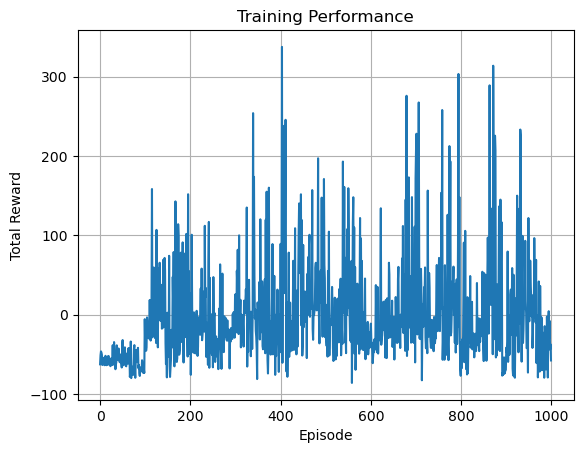

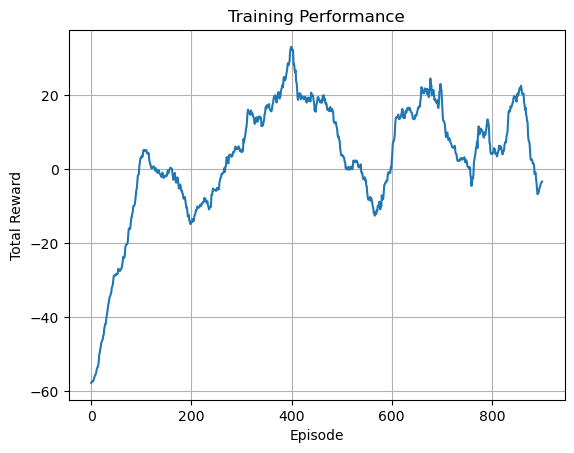

In [21]:
if __name__ == "__main__":
    train(episodes=1000)


In [2]:
print(torch.cuda.is_available())


True
